# Spitzer-ulens Tutorial Notebook
This notebook aims to demonstrate the usage of the main functions in the Spitzer-ulens package.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import pickle
import emcee
import time as ti
from tqdm import tqdm
import os
from multiprocessing import Pool

from Spitzer_ulens import data_config
from Spitzer_ulens.MuLensEvent import MuLensEvent
from Spitzer_ulens import models
from Spitzer_ulens import PLD
from Spitzer_ulens import plot
from Spitzer_ulens import mcmc

## Defining Variables
These can be modified for use with different events and different models.

In [2]:
EVENT_NAME = 'ob171140'
TELESCOPE = 'spitzer'
EVENT_COORDS = ('17:47:31.93','-24:31:21.6')
#MODELFUNC = models.single_lens
MODELFUNC = models.binary_lens_all

## Configuration and Preparation

In [3]:
load_pkl_from_file = True
load_centroid_from_file = True
save_event = True

if load_pkl_from_file and load_centroid_from_file:
    # Load event object from pre-existing pickle file
    filename = 'data/'+EVENT_NAME+'/PLD_input/'+EVENT_NAME+'_'+TELESCOPE+'.pkl'
    with open(filename, 'rb') as input:
        event = pickle.load(input)
else:
    if load_centroid_from_file:
        # Load centroid data from pre-existing centroid.out file
        AOR,TIMES,XDATA,YDATA,CBCD,CBUNC = data_config.load_centroid_data(EVENT_NAME,TELESCOPE)
    else:
        # All data should be downloaded into src_dir directory
        src_dir = 'data'
        # Configure directory structure for use with data_config functions
        data_config.directory_config(EVENT_NAME,TELESCOPE,src_dir)
        # Retrieve raw centroid data
        AOR,TIMES,XDATA,YDATA,CBCD,CBUNC = data_config.get_centroid_data(EVENT_NAME,TELESCOPE,EVENT_COORDS,timerange=(0,8000))
    # Obtain centroid pixel coordinates
    XCENT,YCENT = data_config.target_central_px(XDATA,YDATA)
    # Obtain 5-by-5 images and image errors
    IMG,IMG_E = data_config.target_image_square(EVENT_NAME,XCENT,YCENT,CBCD,CBUNC)
    # Create and save event object
    event = MuLensEvent(EVENT_NAME,TELESCOPE,AOR,TIMES,XDATA,YDATA,IMG,IMG_E)
    event.save()

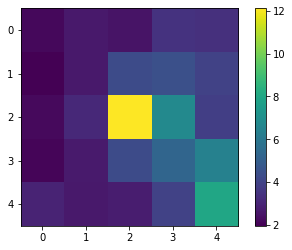

In [4]:
# Plotting an example of a 5-by-5 image
fig,ax = plt.subplots()
im = ax.imshow(event.IMG[1][40])
fig.colorbar(im)
plt.show()

## Least-Squares Fit

Text(0, 0.5, 'Flux (MJy/sr)')

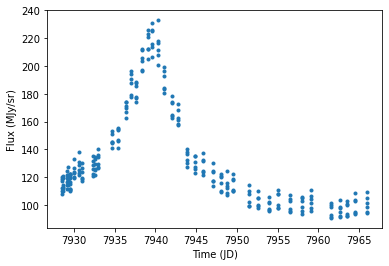

In [5]:
# Get raw photometry, error, and binned error
PTOT,PTOT_E,E_BIN = event.aperture_photometry()
# Flatten in chronological order for plotting purposes
time,ptot = event.chrono_flatten(PTOT)
# Plot our raw data so that we can make some parameter estimates.
plt.plot(time,ptot,'.')
plt.xlabel('Time (JD)')
plt.ylabel('Flux (MJy/sr)')

In [14]:
# Make an initial guess for model parameters, which will be used as starting point for LM fit

# Single lens model:
#fb,t0,fs,tE = 84.86,7940.195,19.707,14.58
#p0 = np.array([fb,t0,fs,tE]) #for single lens: fb, t0, fs, tE

# Binary lens model:
s     = 0.815       # separation between the two lenses (in Einstein radius of total mass)
q     = 0.0099      # mass ratio: Right-lens' mass divided by left-lens' mass
rho   = 1e-6        # source radius in Einstein radii of the total mass.
alpha = np.pi-2.561 # angle between lens axis and source trajectory (rad) VBBL_alpha = PI-OSU_alpha
tE    = 14.58       # einstein radius crossing time
t0    = 7940.195    # time of peak magnification
u0    = 0.1343      # impact parameter
fb    = 76
fs    = 21
p0 = np.asarray([s, q, rho, alpha, tE, t0, u0, fb, fs])
# Estimate some bounds on these parameters. These do not have to be tight constraints.
bounds = ([0,0,0,-np.inf,0,7920,-np.inf,0,0],[np.inf,np.inf,np.inf,np.inf,50,7960,np.inf,150,np.inf])

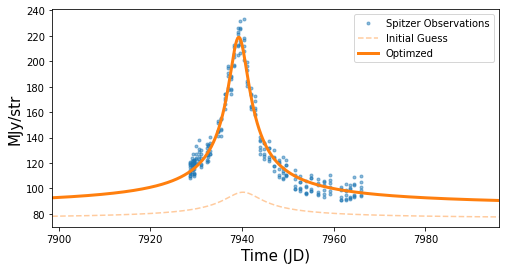

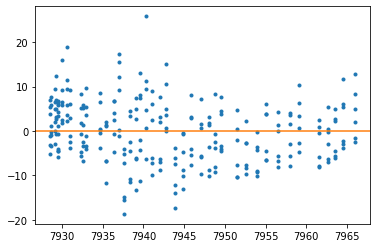

In [24]:
# Obtain raw photometry and errors
PTOT,PTOT_E,E_BIN = event.aperture_photometry()
# Perform LM fit and plot resulting curve
p0_single = np.array([fb,t0,fs,tE])
popt,perr,bestfit,resi_pre,timeplot,lcoptim = event.modelfit(MODELFUNC,p0,PTOT,makeplots=True,bounds=bounds,method='trf')
#popt,perr,bestfit,resi_pre,timeplot,lcoptim = event.modelfit(models.single_lens,p0_single,PTOT,makeplots=True)
plt.figure()
plt.plot(event.chrono_flatten()[0],resi_pre,'.')
plt.axhline(color='C1')

## Solving PLD Coefficients Analytically

In [16]:
# Get fractional flux
PNORM = event.get_PNORM()
# Solve for PLD coefficients analytically
Y, Astro, Ps, A, C, E, X = PLD.analytic_solution(event.TIMES, PTOT, PTOT_E, PNORM, popt, MODELFUNC)
# Get detector model and divide it out to get new best-fit
FIT, SYS, CORR, RESI = PLD.get_bestfit(A, Ps, X, PTOT, Astro)
# Flatten results for plotting
time,ptot,ptot_e,corr,resi,fit,sys = event.chrono_flatten(PTOT,PTOT_E,CORR,RESI,FIT,SYS)
# Compute RMS error before and after
RMS_before, RMS_after = PLD.get_RMS(resi_pre,label='RMS before',visual=True), PLD.get_RMS(resi,label='RMS after',visual=True)
# Plot corrected data, corrected model, and residuals
plot.plot_analytic_solution(time, ptot, fit, corr, resi, timeplot, lcoptim)

TypeError: binary_lens_all() missing 5 required positional arguments: 'tE', 't0', 'u0', 'fb', and 'fs'

## MCMC fit for PLD Parameters

In [19]:
load_chain_from_file = False

if load_chain_from_file:
    # Load chain from file
    path = os.path.join('data',EVENT_NAME,'mega_MCMC')
    chain = np.load(path+'/samplerchain.npy')
    lnprob = np.load(path+'/samplerlnpro.npy')
    posit = np.load(path+'/samplerposit.npy')
    PLD_chain = np.load(path+'/PLD_chain.npy')
else:
    PLD_coeffs = np.empty(np.size(X))
    PLD_chain = mcmc.PLDCoeffsChain(PLD_coeffs)
    sampler = mcmc.get_MCMC_sampler(popt,MODELFUNC,event.TIMES,PTOT,PTOT_E,E_BIN,PNORM,PLD_chain,pool=Pool(),bounds=bounds)
    pos0 = [popt*(1+1e-5*np.random.randn(sampler.ndim))+1e-5*np.abs(np.random.randn(sampler.ndim)) for i in range(sampler.nwalkers)]
    chain,posit,lnprob = mcmc.run_MCMC(sampler,pos0)
    PLD_chain = PLD_chain.chain
    mcmc.save_chain(EVENT_NAME,chain,posit,lnprob,PLD_chain)

Running burn-in


100%|█████████████████████████████████████████| 300/300 [05:44<00:00,  1.15s/it]


Mean burn-in acceptance fraction: 0.407
MCMC runtime = 5.75 min

Running second burn-in


100%|█████████████████████████████████████████| 300/300 [01:27<00:00,  3.44it/s]


Mean burn-in acceptance fraction: 0.437
MCMC runtime = 1.45 min

Running production


100%|███████████████████████████████████████| 1000/1000 [03:16<00:00,  5.08it/s]


Mean acceptance fraction: 0.396
MCMC runtime = 3.28 min



In [25]:
popt_mcmc = np.mean(posit,axis=0)
print(popt_mcmc)
print(p0)
print(popt)

[9.14850651e-01 2.65068011e-02 1.08081748e-03 7.24079852e-01
 1.27726584e+01 7.93892893e+03 1.51070684e-01 7.60194511e+01
 2.46500673e+01]
[8.15000000e-01 9.90000000e-03 1.00000000e-06 5.80592654e-01
 1.45800000e+01 7.94019500e+03 1.34300000e-01 7.60000000e+01
 2.10000000e+01]
[9.62383714e-01 7.21233649e-03 1.26123722e-03 7.87890999e-01
 1.71153484e+01 7.93909375e+03 1.32351093e-01 7.67456645e+01
 1.99429574e+01]


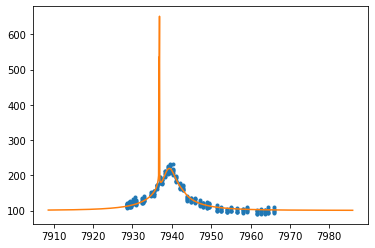

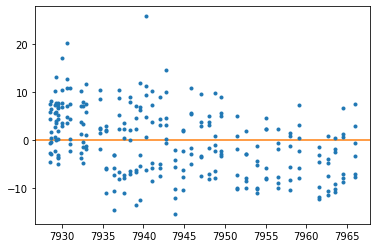

In [21]:
timeplot = np.linspace(time[0]-20,time[-1]+20,1000)
plt.figure(0)
plt.plot(time,ptot,'.')
plt.plot(timeplot,MODELFUNC(timeplot,*popt_mcmc))
resi = ptot-MODELFUNC(time,*popt_mcmc)
plt.figure(1)
plt.axhline(color='C1')
plt.plot(time,resi,'.')

# Error Analysis

By plotting histograms of the chain positions in parameter space, we can estimate 1 sigma, 2 sigma, etc. errors on our parameters.

(100, 9)


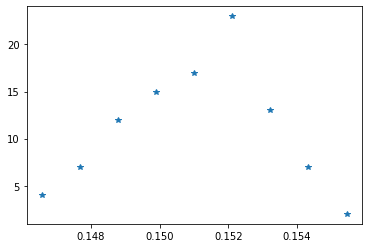

In [68]:
print(posit.shape)
nbins=10
i = 6
pmin = posit.min(axis=0)
pmax = posit.max(axis=0)
bins = np.linspace(pmin,pmax,nbins)
aa,bb = np.histogram(posit[:,i],bins[:,i])
cents = 0.5*(bb[1:]+bb[:-1])
plt.plot(cents,aa,'*')
#plt.plot(posit[:,0])

In [46]:
print(posit[0])
print(posit[1])
print(pos_max)

[9.19314521e-01 2.39826711e-02 1.30811686e-03 7.27272107e-01
 1.29082161e+01 7.93895149e+03 1.52200628e-01 7.53615818e+01
 2.49388507e+01]
[9.14106986e-01 2.48379529e-02 6.86572132e-04 7.18410394e-01
 1.29538301e+01 7.93895298e+03 1.49208559e-01 7.60803593e+01
 2.43776768e+01]
[9.24138707e-01 3.18129873e-02 3.10912210e-03 7.33019673e-01
 1.33959708e+01 7.93898644e+03 1.56003569e-01 7.81784205e+01
 2.57036067e+01]
